Video: https://youtu.be/7pHJ_3qdrEs

Aluno: Radhanama Dasa De Maria Moraes Mesiano

Matricula: 2012507BCC

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from os.path import join
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Classificação de clientes

## Carga e inspeção dos dados

In [3]:
# Definição dos nomes das variáveis (conforme a tabela contida no enunciado)
colnames = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC',
            'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']

In [4]:
# Leitura dos dados de treino
arquivo = './credtrain.txt'
data_train = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

# Leitura dos dados de teste
arquivo = './credtest.txt'
data_test = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

**Inspeção dos dados**

In [5]:
# Inspeção da dimensão do dataset
print(data_train.shape, data_test.shape)

(1500, 12) (577, 12)


In [6]:
# Inspeção das primeiras linhas do conjunto de treinamento
data_train.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [7]:
# Inspeção das primeiras linhas do conjunto de teste
data_test.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,0,2,500,1,618,10,85,0,36,6,0,0
1,1,0,813,0,552,4,119,0,43,48,119,1
2,3,0,350,0,488,12,66,0,43,0,0,1
3,1,0,1530,0,381,1,398,0,28,48,0,1
4,0,0,688,1,396,10,60,0,49,72,0,1


## Pré-processamento dos dados

### Transformação de variáveis categóricas

A variável ESCT (Estado Civil) é categórica, podendo assumir 4 valores diferentes (cada valor corresponde a um estado civil). Repare que não há uma ordem definida sobre esse valores. Para comparação, considere a variável NDEP (que corresponde à quantidade de dependentes do cliente). 

A presença de variáveis categóricas em um conjunto de treinamento pode dificultar a geração do modelo de classificação. Isso porque a maioria dos algoritmos de aprendizado (as redes neurais incluídas) presumem a existência de uma ordem total sobre os valores de uma variável. Para mitigar este problema, uma alternativa é transformar a variável ESCT em diversas variáveis *dummy* (variável binária). Uma variável *dummy* é uma variável binária utilizada para representar categorias. Sendo assim, a variável ESCT será transformada em 4 "variantes dummy", onde o valor 1 corresponderá à ocorrência de determinada categoria e o valor 0 corresponderá à não ocorrência.

In [8]:
# Aplicação no conjunto de treinamento
data_train_new = pd.get_dummies(data = data_train, 
                                prefix='ESCT', 
                                columns=['ESCT'], 
                                drop_first=True)

"""
pd.get_dummies: Convert categorical variable into dummy/indicator variables.
"""

# Inspeção das primeiras linhas
data_train_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,0,360,0,313,9,52,0,25,48,0,1,1,0,0
1,0,350,1,468,10,65,0,33,6,0,1,0,0,0
2,0,1100,0,829,9,125,0,56,48,0,1,0,0,0
3,0,3000,0,552,12,76,1,31,60,0,1,0,0,0
4,0,1000,0,809,12,111,0,24,7,0,1,1,0,0


In [9]:
# Aplicação da transformação sobre o conjunto de teste
data_test_new = pd.get_dummies(data = data_test, prefix='ESCT', columns=['ESCT'], drop_first=True)

"""
pd.get_dummies: Convert categorical variable into dummy/indicator variables
"""

# Inspeção das primeiras linhas
data_test_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,2,500,1,618,10,85,0,36,6,0,0,0,0,0
1,0,813,0,552,4,119,0,43,48,119,1,1,0,0
2,0,350,0,488,12,66,0,43,0,0,1,0,0,1
3,0,1530,0,381,1,398,0,28,48,0,1,1,0,0
4,0,688,1,396,10,60,0,49,72,0,1,0,0,0


**Separação do conjunto de dados em rótulo ($\mathrm{y}$) e features ($\mathrm{x}$)**

O rótulo ($\mathrm{y}$) corresponde ao vetor contendo a variável alvo (CLASSE), enquanto que features ($\mathrm{x}$) corresponde à matriz de dados. É importante converter para vetor para que a partir dele criemos um tensor PyTorch. Não podemos fazer a conversão direta de um objeto pandas Dataframe para um tensor PyTorch.

In [10]:
# Transformação da variável alvo do conjunto de treinamento e teste em vetor
y_train = np.array(data_train_new['CLASSE'])
y_test = np.array(data_test_new['CLASSE'])

In [11]:
# Transformação da variável alvo do conjunto de teste em vetor

# Inspeção das primeiras linhas
y_test[:5]

array([0, 1, 1, 1, 1])

In [12]:
# Transformação do conjunto de treinamento remanescente em matriz de dados
features_name_train = list(data_train_new.columns)               # nomes das colunas
features_name_train.remove('CLASSE')                             # remove variável "CLASSE"
X_train = np.array(data_train_new.loc[:, features_name_train])   # Transformação em matriz de dados
X_train = X_train.astype(float)
X_train.dtype

dtype('float64')

In [13]:
# Inspeção da matriz resultante
X_train

array([[0.00e+00, 3.60e+02, 0.00e+00, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 3.50e+02, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 1.10e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [0.00e+00, 5.70e+02, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 3.60e+02, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.00e+00, 5.01e+02, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [14]:
# Transformação do conjunto de teste remanescente em matriz de dados
features_name_test = list(data_test_new.columns)               # Nomes das colunas
features_name_test.remove('CLASSE')                            # Remoção da variável "CLASSE"
X_test = np.array(data_test_new.loc[:, features_name_test])    # Transformação em matriz
X_test = X_test.astype(float)

In [15]:
# Inspeção da matriz resultante
X_test

array([[2.00e+00, 5.00e+02, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 8.13e+02, 0.00e+00, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 3.50e+02, 0.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       ...,
       [3.00e+00, 1.20e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 6.00e+02, 0.00e+00, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 8.00e+02, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

### Normalização das features

Antes de iniciar o treinamento, é também necessário realizar a *normalização* das características a fim de evitar eventuais problemas decorrentes à discrepância nas ordens de grandeza das features.

In [16]:
# Criação do objeto para a padronização das features
scaler = StandardScaler()

# Ajustamento do StandardScaler ao conjunto de dados de treino e padronização dos dados de treino
X_train = scaler.fit_transform(X_train)

# Transformação dos dados de teste com os parâmetros ajustados a partir dos dados de treino
X_test = scaler.transform(X_test)

In [17]:
# Dimensões dos datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1500, 13) (577, 13) (1500,) (577,)


## Treinamento do modelo

importando modelos

In [18]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

executar os modelos

In [19]:
models = []
models.append(XGBClassifier)
models.append(DecisionTreeClassifier)
models.append(RandomForestClassifier)
models.append(KNeighborsClassifier)
models.append(MLPClassifier)
models.append(LogisticRegression)

model_classifier = []
for model in models:
  classifier = model()
  classifier.fit(X_train, y_train)
  model_classifier.append(classifier)

## Validação do modelo

As métricas para validação que usamos aqui são as seguintes:

* *precision* é o percentual de valores previstos como positivos que realmente são positivos (1 - cliente pagar o empréstimo), em relação ao total de previsões (soma dos verdadeiros e falsos positivos). Temos essa medida também relacionada ao valor 0 da variável alvo, com definição análoga. Essa medida consiste basicamente em identificar a proporção de previsões corretas do modelo, em relação ao total de previsões realizadas.

* *recall* consiste no seguinte: Dentre todos os exemplos da classe 1, que proporção o modelo acertou. A definição é análoga para os exemplos da classe 0. Essa medida consiste na capacidade do modelo prever um determinado valor do alvo, i.e., o quanto ele é capaz de prever 0, e o quanto ele é capaz de prever 1.

* f1-score é a média harmônica entre o recall e a precision.

* *support* é a quantidade de ocorrências de exemplos de uma dada classe. Um desequilibrio nos valores indicados podem nos mostrar que as medidas de avaliação ainda estão fracas. Não é o caso, então as medidas estão confiáveis. Porém, se fosse o caso, talvez fosse necessária uma amostragem estratificada, ou um rebalanceamento nos dados. O suporte funciona como um diagnóstico para a avaliação.

In [20]:
target_names = ['0', '1']
preds = []
for model in model_classifier:
  y_pred = model.predict(X_test)
  preds.append(y_pred)
  print("\n\n"+model.__class__.__name__+ ": \n"+ classification_report(y_test, y_pred, target_names=target_names))



XGBClassifier: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       306
           1       0.97      0.83      0.89       271

    accuracy                           0.91       577
   macro avg       0.92      0.90      0.90       577
weighted avg       0.91      0.91      0.91       577



DecisionTreeClassifier: 
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       306
           1       0.83      0.87      0.85       271

    accuracy                           0.86       577
   macro avg       0.86      0.86      0.86       577
weighted avg       0.86      0.86      0.86       577



RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       306
           1       0.95      0.82      0.88       271

    accuracy                           0.90       577
   macro avg       0.91      0.89      0.90       577
we

#### Matriz de confusão

A matriz de confusão nos ajuda a ver a proporção entre erros e acertos. Os rótulos "0" e "1" na "margem" inferior da matriz são os valores previstos em cada caso. Da mesma forma, os rótulos na margem esquerda indicam a resposta correta. 

A diagonal principal, que está colorida em tons de roxo, indica o percentual de previsões corretas para cada classe. 

A diagonal mais clara indica o percentual de erros para cada classe.

Podemos ver que os percentuais de acertos para cada classe são maiores em relação aos percentuais de erro. Isso é um indicativo de que os parâmetros do modelo foram ajustados corretamente durante o aprendizado.

In [21]:
cms = []
for i, y_pred in enumerate(preds):
  cm = confusion_matrix(y_test, y_pred)
  # print("\n"+model_classifier[i].__class__.__name__)
  # print(cm/np.sum(cm))
  cms.append(cm)


DecisionTreeClassifier


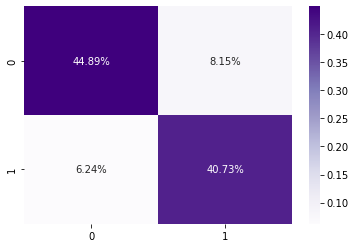

In [22]:
print("\n"+model_classifier[1].__class__.__name__)
sns.heatmap(cms[1]/np.sum(cms[1]), annot=True, fmt='.2%', cmap='Purples')


RandomForestClassifier


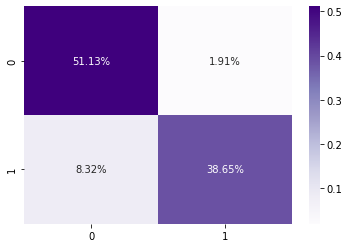

In [23]:
print("\n"+model_classifier[2].__class__.__name__)
sns.heatmap(cms[2]/np.sum(cms[2]), annot=True, fmt='.2%', cmap='Purples')


KNeighborsClassifier


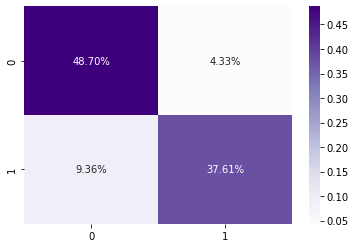

In [24]:
print("\n"+model_classifier[3].__class__.__name__)
sns.heatmap(cms[3]/np.sum(cms[3]), annot=True, fmt='.2%', cmap='Purples')


MLPClassifier


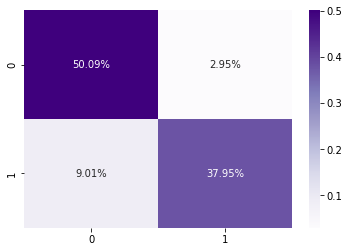

In [25]:
print("\n"+model_classifier[4].__class__.__name__)
sns.heatmap(cms[4]/np.sum(cms[4]), annot=True, fmt='.2%', cmap='Purples')


LogisticRegression


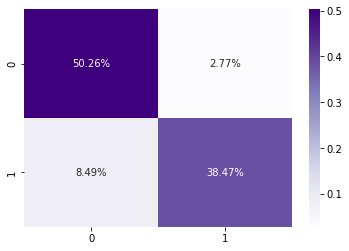

In [26]:
print("\n"+model_classifier[5].__class__.__name__)
sns.heatmap(cms[5]/np.sum(cms[5]), annot=True, fmt='.2%', cmap='Purples')


XGBClassifier


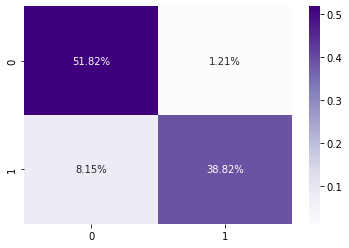

In [27]:
print("\n"+model_classifier[0].__class__.__name__)
sns.heatmap(cms[0]/np.sum(cms[0]), annot=True, fmt='.2%', cmap='Purples')

 # Predição de preços de diamantes

## Carga e inspeção dos dados

In [28]:
df_diamonds = pd.read_csv("diamonds.csv")
df_diamonds.head(10)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [29]:
df_diamonds = df_diamonds.drop(["Unnamed: 0"],axis=1)
df_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [30]:
colnames = [column for column in df_diamonds.columns]
colnames

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

## Pré-processamento dos dados

Esta etapa é muito importante, uma má execução desta etapa pode causar problemas no treino. 

Aqui, verificamos os valores presentes em colunas que sabemos que se tratam de dados categóricos. Então é necessário pensar se estes dados são *nominais* (valor que indica categoria, sem levar em consideração um "ranking") ou *ordinais* (valor que indica categoria, mas que carrega uma relação de ordem com demais valores presentes).

Podemos ver que os dados são ordinais. Podemos ver que há valores para os quais vai haver um corte, cor ou claridade do diamante que vai ser ideal ou não, então isso é modelado na codificação.

In [31]:
print(df_diamonds['cut'].unique())
print(df_diamonds['color'].unique())
print(df_diamonds['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [32]:
df_diamonds['cut'].replace({'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}, inplace=True)
df_diamonds['color'].replace({'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}, inplace=True)
df_diamonds['clarity'].replace({'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}, inplace=True)

In [33]:
print(df_diamonds['cut'].unique())
print(df_diamonds['color'].unique())
print(df_diamonds['clarity'].unique())

[5 4 2 3 1]
[6 2 1 3 5 4 7]
[2 3 5 4 6 7 1 8]


In [34]:
df_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


In [35]:
# Divisão entre treino e teste
X = df_diamonds.drop(['price'], 1)
y = df_diamonds['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### Normalização das features
É importante normalizarmos as features para equilibrar as suas ordens de grandeza, para os mesmos serem processados na etapa de treino. Isso é feito porque a existência de discrepâncias entres essas orders de grandeza prejudica o ajuste dos modelos em alguns algoritmo de aprendizado.

É também importante entender que o ajuste do *scaler* deve ser feito apenas sobre o conjunto de treino,
para evitar que haja vazamento de dados (fenômeno conhecido como [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)).

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Dimensões dos datasets

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(43152, 9)
(43152,)
(10788, 9)
(10788,)


## Treinamento do modelo

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

In [39]:
models = []
models.append(LinearRegression)
models.append(Lasso)
models.append(DecisionTreeRegressor)
models.append(RandomForestRegressor)
models.append(KNeighborsRegressor)
models.append(MLPRegressor)
models.append(XGBRegressor)

model_regressor = []
for model in models:
  regressor = model()
  regressor.fit(X_train, y_train)
  model_regressor.append(regressor)

[23:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
for model in model_regressor:
  cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=12)
  print(model.__class__.__name__+" (cv12): %f " % (-1 * cv_score.mean()))

LinearRegression (cv12): 1224.303681 
Lasso (cv12): 1223.661525 
DecisionTreeRegressor (cv12): 752.284242 
RandomForestRegressor (cv12): 551.031628 
KNeighborsRegressor (cv12): 738.455913 
MLPRegressor (cv12): 859.014475 
[23:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:28] WARNI

## Validação do modelo

Definimos a função de custo como sendo a MSE, cujo propósito é calcular o erro médio entre os valores corretos de target no conjunto de treino e os valores previstos pela rede nesta etapa. 

Para validar o modelo treinado, utilizamos a métrica de avaliação conhecida como [coeficiente de determinação](https://en.wikipedia.org/wiki/Coefficient_of_determination), denotada por $R^2$. O cálculo dessa métrica é descrito a seguir.

Digamos que tenhamos um modelo que seja um gráfico no plano que representa a média dos valores de target, e tenhamos a distribuição dos dados. Então podemos calcular o erro entre este modelo e cada ponto de dados, e elevar ao quadrado, e somar estes erros. Esta soma é chamada de **soma dos quadrados totais** ($SQ_t$).

Agora, suponha que tenhamos o modelo treinado. Calculamos o resíduo, que é o erro do modelo em relação a cada exemplo elevado ao quadrado. Em seguida, somamos todos os desvios. Essa soma é chamada de **soma dos quadrados dos resíduos** (SQ${_r}$). 

Para computar o $R^2$, fazemos: 
$$
R^2 = \frac{(SQ_t - SQ_r)}{SQ_t}
$$
Onde o $SQ_t$ vai realizar uma normalização para que o resultado esteja num escala de 0 até 1. 

O valor de $R^2$ pode ser interpretado como a qualidade preditiva do modelo treinado em comparação com um modelo que prediz simplesmente a média dos valores alvo. 

In [41]:
from sklearn import metrics 

# Model prediction on test data with XGBClassifier which gave us the least RMSE 
for regressor in model_regressor:
  y_pred = regressor.predict(X_test)
  print("R^2:", metrics.r2_score(y_test, y_pred))

R^2: 0.9063618468720546
R^2: 0.9062978278048544
R^2: 0.9657716810800077
R^2: 0.9817283833788555
R^2: 0.9668370722195156
R^2: 0.9614229570787247
R^2: 0.9741694856025805


O resultado acima indica que o modelo foi corretamente ajustado.

#Como foi implemnetado.

Para a implementação e comparação dos modelos escolhi usar listas onde eu criava uma lista com todos os modelos e executava todos de uma vez em um for, e quando usei o a função fit() e a função cross_val_score() eu coloquei tudo isso em um for também e fui salvando os resultados em uma lista, e para não me perder e identificar os modelos eu printei o nome de cada classe.